In [1]:
import numpy as np
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d, interp2d
from scipy.optimize import root
from scipy.special import zeta
from astropy import constants as C
from astropy import units
from astropy.cosmology import Planck15 as cosmo
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = plt.rcParams['axes.labelsize'] = plt.rcParams['xtick.labelsize'] = plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['mathtext.fontset'] = 'dejavuserif'

In [2]:
Mp = (np.sqrt(C.hbar*C.c/(8*np.pi*C.G)) * C.c**2).to(units.GeV)
T0 = (C.k_B * cosmo.Tcmb0).to(units.GeV)
rho0 = (cosmo.critical_density0 * C.hbar**3 * C.c**5).to(units.GeV**4)

In [3]:
m_edges = np.linspace(-12, 3, 201) 
sigma_edges = np.linspace(-12, -6, 201) 
m = np.power(10, 0.5*(m_edges[1:]+m_edges[:-1])) * units.GeV
sigma = np.power(10, 0.5*(sigma_edges[1:]+sigma_edges[:-1])) * units.GeV**(-2)
g = 1

In [4]:
def plot(Odm, medges=None, sigmaedges=None, vmin=None, vmax=None):
    medges = np.power(10, m_edges if medges is None else medges)
    sigmaedges = np.power(10, sigma_edges if sigmaedges is None else sigmaedges)
    
    fig, ax = plt.subplots()
    pcm = ax.pcolormesh(medges, sigmaedges, Odm,
                        cmap='jet',
                        norm=mpl.colors.LogNorm(vmin=vmin, vmax=vmax))
    ax.set_xscale('log')
    ax.set_yscale('log')
    
    ax.set_xlabel('$m$')
    ax.set_ylabel(r'$\left\langle{\sigma v}\right\rangle_{fo}, \mathrm{GeV}^{-2}$')
    ax.set_xlim(1e-12, 1e3)
    ax.xaxis.set_ticks((1e-12, 1e-9, 1e-6, 1e-3, 1, 1e3))
    ax.xaxis.set_ticklabels((r'$\mathrm{meV}$', r'$\mathrm{eV}$', r'$\mathrm{keV}$', r'$\mathrm{MeV}$', r'$\mathrm{GeV}$', r'$\mathrm{TeV}$'))
    cax = plt.colorbar(pcm)
    cax.set_label(r'$\Omega_{\mathrm{DM}, 0}$', rotation=-90, verticalalignment='bottom')
    return fig, ax, cax

def get_match(sigma, Odm0, fill_value=np.nan):
    match = []
    diff = Odm0 - cosmo.Odm0
    diff[np.isnan(diff)] = np.inf
    initial_guesses = sigma[np.nanargmin(np.abs(diff), axis=0)]
    for i in range(Odm0.shape[1]):
        ipol = interp1d(sigma, Odm0[:, i], kind='linear', bounds_error=False, fill_value=fill_value)
        res = root(lambda x: ipol(x) - cosmo.Odm0, initial_guesses[i], tol=0.01)
        match.append(res.x[0] if res.success else np.nan)
    return np.array(match)

### Part 1: Instantaneous freeze-out

#### a. Relativistic (hot) dark matter

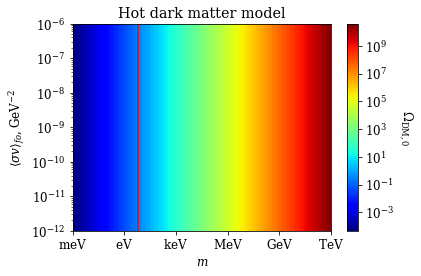

In [5]:
Ohdm0 = ((zeta(3)/np.pi**2) * (T0**3 / rho0) * g * m).to('').value
fig, ax, cax = plot(np.broadcast_to(Ohdm0, np.broadcast(m[None, :], sigma[:, None]).shape))
ax.vlines((cosmo.Odm0 * (np.pi**2 / zeta(3)) * (rho0 / T0**3) / g).to('GeV').value,  
          np.power(10, sigma_edges[0]), np.power(10, sigma_edges[-1]), colors='r')
ax.set_title('Hot dark matter model')
fig.tight_layout()

#### b. Non-relativistic (cold) dark matter

In [6]:
A = (((2*np.pi)**(3/2) / g) / (Mp * m[None, :] * sigma[:, None])).to('').value

def solve_x_fo(a):
    return np.nan if a > np.exp(-1) else root(lambda x: np.sqrt(x)*np.exp(-x)-a, 1).x

x_fo = np.vectorize(solve_x_fo)(A)
Ocdm0 = (T0**3 / (rho0 * Mp)) * x_fo / sigma[:, None]

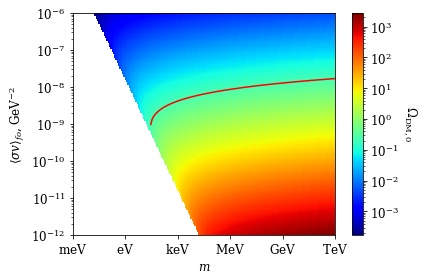

In [7]:
fig, ax, cax = plot(Ocdm0.value)
ax.plot(m.value, get_match(sigma, Ocdm0), 'r-')
fig.tight_layout()

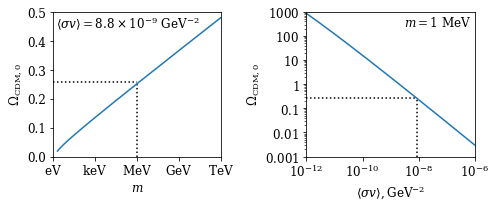

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(7, 3))

ax[0].semilogx(m, Ocdm0[131, :].to('').value)
ax[0].text(0.02, 0.98, r'$\left\langle\sigma v\right\rangle = 8.8\times10^{-9}\ \mathrm{GeV}^{-2}$', fontsize=12,
           transform=ax[0].transAxes, verticalalignment='top')
ax[0].set_ylabel(r'$\Omega_{\mathrm{CDM}, 0}$')
ax[0].set_xlabel('$m$')
ax[0].xaxis.set_ticks((1e-9, 1e-6, 1e-3, 1, 1e3))
ax[0].xaxis.set_ticklabels((r'$\mathrm{eV}$', r'$\mathrm{keV}$', r'$\mathrm{MeV}$', r'$\mathrm{GeV}$', r'$\mathrm{TeV}$'))
ax[0].set_ylim(0, 0.5)
ax[0].set_xlim(1e-9, 1e3)
ax[0].vlines(1e-3, ax[0].get_ylim()[0], cosmo.Odm0, linestyles=':')
ax[0].hlines(cosmo.Odm0, ax[0].get_xlim()[0], 1e-3, linestyles=':')

ax[1].loglog(sigma, Ocdm0[:, 120])
ax[1].text(0.98, 0.98, r'$m = 1\ \mathrm{MeV}$', fontsize=12,
          transform=ax[1].transAxes, verticalalignment='top', horizontalalignment='right')
ax[1].set_ylabel(r'$\Omega_{\mathrm{CDM}, 0}$')
ax[1].set_xlabel(r'$\left\langle\sigma v\right\rangle, \mathrm{GeV}^{-2}$')
ax[1].set_xlim(0.5e-12, 2e-6)
ax[1].set_xticks(np.power(10., np.arange(-12, -5, 2)))
ax[1].yaxis.set_ticks((1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3))
ax[1].yaxis.set_ticklabels(('$0.001$', '$0.01$', '$0.1$', '$1$', '$10$', '$100$', '$1000$'))
ax[1].set_xlim(1e-12, 1e-6)
ax[1].set_ylim(1e-3, 1e3)
ax[1].vlines(sigma[131].value, ax[1].get_ylim()[0], cosmo.Odm0, linestyles=':')
ax[1].hlines(cosmo.Odm0, ax[1].get_xlim()[0], sigma[131].value, linestyles=':')
fig.tight_layout()

In [9]:
def neq_overm3(x, g=1):
    return (g / (2 * np.pi * x)**(3/2)) * np.exp(-x)
def s_overm3(x, gs):
    return (2*np.pi**2/45) * gs / x**3
def Yeq(x, gs, g=1):
    return neq_overm3(x, g) / s_overm3(x, gs)

T_data, gsm_data = np.loadtxt('week_1_resources/week_1_g.csv', delimiter=',', unpack=True)
gsm = interp1d(T_data*units.GeV, gsm_data, fill_value='extrapolate')

Tmid_data = (T_data[:-1]+T_data[1:])/2
lngsmderiv_data = np.diff(np.log(gsm_data)) / np.diff(np.log(T_data))
lngsmderiv = interp1d(Tmid_data*units.GeV, lngsmderiv_data, fill_value='extrapolate')

def Riccati(x, y, mGeV, B, g=1):
    s = s_overm3(x, gsm(mGeV/x))
    return B * s * x * ((neq_overm3(x, g)/s)**2 - y**2) * (1 + lngsmderiv(mGeV/x) / 3)

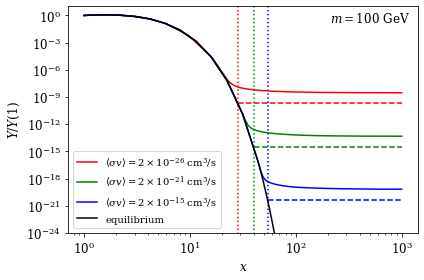

In [10]:
log10xmax = 3

m1 = 100*units.GeV
yi = Yeq(1, gsm(m1))

for sexp, clr in zip((-26, -21, -15), ('r', 'g', 'b')):
    sigma1 = 2*10**sexp * (units.cm**3/units.s)/C.c
    sigma1 = (sigma1/(C.hbar*C.c)**2).to(units.GeV**(-2))
    sol = solve_ivp(lambda logx, logy:
                        Riccati(np.exp(logx), np.exp(logy),
                                m1, Mp*m1*sigma1)
                        * np.exp(logx-logy),
                    (0, log10xmax*np.log(10)), [np.log(yi)],
                    method='BDF')
    x, y = np.exp(sol.t), np.exp(sol.y[0]) / yi
    l, = plt.loglog(x, y, clr,
                    label=r'$\left\langle\sigma v\right\rangle = 2\times10^{'+str(sexp)+'}\ \mathrm{cm}^3/\mathrm{s}$')
    x_fo = solve_x_fo(1/(Mp*m1*sigma1))
    y_fo = Yeq(x_fo, gsm(m1 / x_fo)) / yi
    plt.vlines(x_fo, 1e-25, 1e5,
               colors=l.get_color(), linestyles=':')
    plt.hlines(y_fo, x_fo, np.power(10, log10xmax),
               colors=l.get_color(), linestyles='--')
plt.loglog(x, Yeq(x, gsm(m1/x)) / yi, 'k', label='equilibrium')
plt.text(0.98, 0.98, '$m = 100\ \mathrm{GeV}$', fontsize=12,
        transform=plt.gca().transAxes, verticalalignment='top', horizontalalignment='right')
plt.ylim(1e-24, 1e1)
plt.xlabel('$x$')
plt.ylabel('$Y / Y(1)$')
plt.legend(loc='lower left')
plt.tight_layout()

In [11]:
@np.vectorize
def solve_y0(m, B, yi, log10xmax):
    if np.isnan(solve_x_fo(((2*np.pi)**(3/2) / g) / B)):
        return np.nan
    else:
        sol = solve_ivp(lambda logx, logy:
                            Riccati(np.exp(logx), np.exp(logy),
                                    m, B)
                            * np.exp(logx-logy),
                        (0, log10xmax*np.log(10)), [np.log(yi)],
                        method='BDF')
        return np.exp(sol.y[0][-1])

if False:  # Set to True to run
    %time y0 = solve_y0(m.to(units.GeV).value[None, :], (Mp*m[None, :]*sigma[:, None]).to('').value, Yeq(1, gsm(m)), log10xmax)
    np.savez_compressed('week_1_resources/week_1_exact.npz', y0=y0, m_edges=m_edges, sigma_edges=sigma_edges)

CPU times: user 35min 43s, sys: 24.6 s, total: 36min 7s
Wall time: 37min 3s


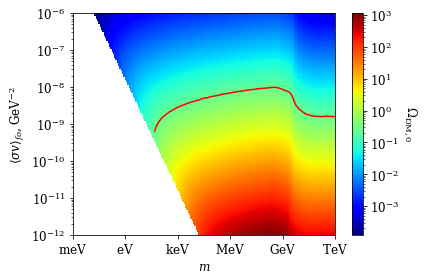

In [12]:
y0 = np.load('week_1_resources/week_1_exact.npz')['y0']

Ocdm0_exact = (s_overm3(m/T0, gsm(T0)) * m**4 * y0/rho0).to('').value
fig, ax, cax = plot(Ocdm0_exact, m_edges, sigma_edges)

match = get_match(sigma, Ocdm0_exact, 'extrapolate')
ax.plot(m.value, np.where(np.array(match) > 0, match, np.nan), 'r-')
fig.tight_layout()